## Feature Description

enrollee_id : Unique ID for candidate

city: City code

city_ development _index : Developement index of the city (scaled)

gender: Gender of candidate

relevent_experience: Relevant experience of candidate

enrolled_university: Type of University course enrolled if any

education_level: Education level of candidate

major_discipline :Education major discipline of candidate

experience: Candidate total experience in years

company_size: No of employees in current employer's company

company_type : Type of current employer

lastnewjob: Difference in years between previous job and current job

training_hours: training hours completed

target: 0 – Not looking for job change, 1 – Looking for a job change

In [199]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.impute import SimpleImputer
sns.set()

In [106]:
path= r'C:\Satyaki\DATASETS\kaggle_hr_analytics'
os.chdir(path)
# Reading relevant data from the files
hr_train=pd.read_csv('aug_train.csv')
hr_test=pd.read_csv('aug_test.csv')
hr_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [107]:
print(f'Train_shape: {hr_train.shape}')
print(f'Test_shape:  {hr_test.shape}')

Train_shape: (19158, 14)
Test_shape:  (2129, 13)


## Data Cleaning

In [108]:
hr_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [109]:
# checking for percentage of missing values
100*hr_train.isnull().sum()/len(hr_train)

enrollee_id                0.000000
city                       0.000000
city_development_index     0.000000
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
last_new_job               2.207955
training_hours             0.000000
target                     0.000000
dtype: float64

1. The columns with small percentage of missing values(<5%) will be imputed. 
2. Columns where there are larger number of missing values,missing values will be treated as a separate category

In [110]:
special_impute=['gender','major_discipline','company_size','company_type']
normal_impute=['enrolled_university','education_level','last_new_job','experience']

# replacing large number of missing values with the string 'N/A'
hr_train[special_impute]=hr_train[special_impute].fillna('N/A')
hr_test[special_impute]=hr_test[special_impute].fillna('N/A')

# replacing smaller number of missing values with central imputation
si=SimpleImputer(strategy='most_frequent')
hr_train[normal_impute]=si.fit_transform(hr_train[normal_impute])
hr_test[normal_impute]=si.transform(hr_test[normal_impute])

In [111]:
hr_train.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [112]:
## Modifying the experience column
## The >20 and <1 categories are being replaced by numbers but will be treated as ordinal variables in the analysis
hr_train['experience']=hr_train['experience'].replace({'>20':'21','<1':'0'})
hr_test['experience']=hr_test['experience'].replace({'>20':'21','<1':'0'})

# Modifying time since last new job
hr_train['last_new_job']=hr_train['last_new_job'].replace({'never':'0','>4':'5'})
hr_test['last_new_job']=hr_train['last_new_job'].replace({'never':'0','>4':'5'})

# Modifying company size column
hr_train['company_size']=hr_train['company_size'].replace({'<10':'type_1','10/49':'type_2','50-99':'type_3','100-500':'type_4','500-999':'type_5',
                                 '1000-4999':'type_6','5000-9999':'type_7','10000+':'type_8'})

hr_test['company_size']=hr_test['company_size'].replace({'<10':'type_1','10/49':'type_2','50-99':'type_3','100-500':'type_4','500-999':'type_5',
                                 '1000-4999':'type_6','5000-9999':'type_7','10000+':'type_8'})


In [115]:
# setting enrolee id as index
hr_train.set_index('enrollee_id',inplace=True)
hr_test.set_index('enrollee_id',inplace=True)

In [116]:
# casting variables to proper data types
num_cols=['city_development_index','training_hours']
cat_cols=hr_train.columns.difference(num_cols).drop('target')

# Converting categorical columns to categorical type data
hr_train[cat_cols]=hr_train[cat_cols].astype('category')
hr_test[cat_cols]=hr_test[cat_cols].astype('category')

# converting continuous variables to type float
hr_train[num_cols]=hr_train[num_cols].astype('float64')
hr_test[num_cols]=hr_test[num_cols].astype('float64')

In [117]:
hr_train.dtypes

city                      category
city_development_index     float64
gender                    category
relevent_experience       category
enrolled_university       category
education_level           category
major_discipline          category
experience                category
company_size              category
company_type              category
last_new_job              category
training_hours             float64
target                     float64
dtype: object

## EDA

In [119]:
# Finding Cardinality for each variable
for col in cat_cols:
    print(f'Cardinality of {col} is {len(np.unique(hr_train[col]))}')

Cardinality of city is 123
Cardinality of company_size is 9
Cardinality of company_type is 7
Cardinality of education_level is 5
Cardinality of enrolled_university is 3
Cardinality of experience is 22
Cardinality of gender is 4
Cardinality of last_new_job is 6
Cardinality of major_discipline is 7
Cardinality of relevent_experience is 2


In [188]:
# function to plot categorical columns
def plot_cat(some_col):
    '''accepts a categorical column'''
    x1,y1=[],[]
    counts=Counter(some_col).items()
    counts=sorted(counts,key=lambda x:x[1],reverse=False)
    for x,y in counts:
        x1.append(x)
        y1.append(y)
    return x1,y1

-----------------Candidate Stays-----------------------


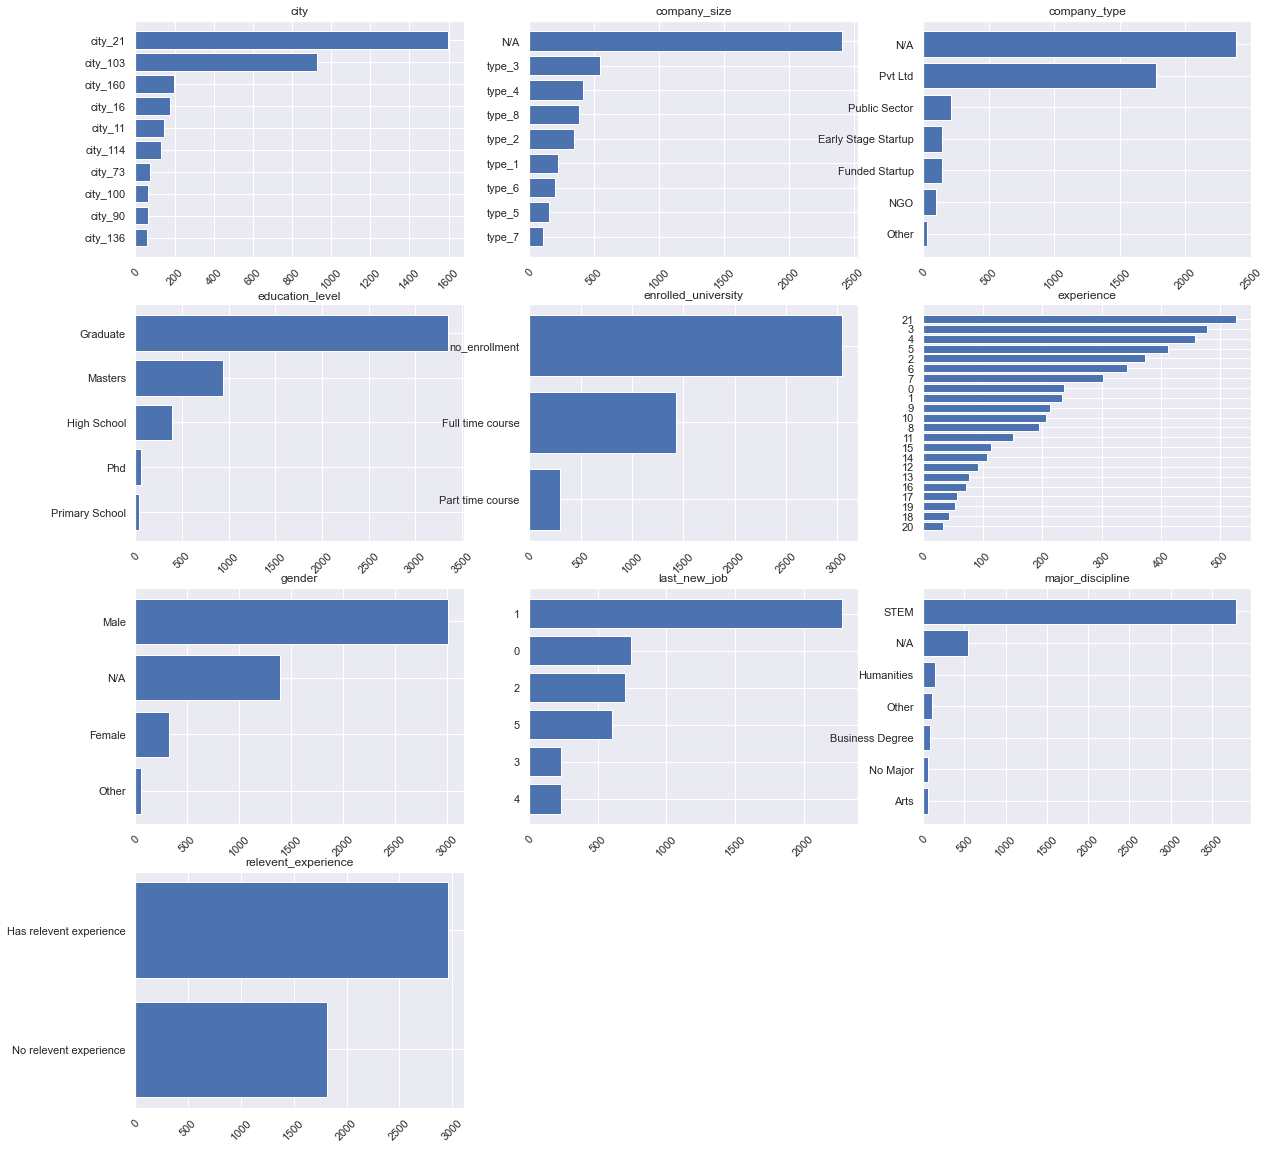

In [195]:
# Plotting all categorical columns for case where candidate stays
plt.figure(figsize=(20,20))
i=1
print('-----------------Candidate leaves-----------------------')
for col in cat_cols:
    x,y=plot_cat(hr_train[col][hr_train.target==1])
    #since there are 100+ cities,only top 10 are being plotted
    if col=='city':
        x,y=x[-10:],y[-10:]
    plt.subplot(4,3,i)
    plt.barh(x,y)
    plt.title(col)
    plt.xticks(rotation=45)
    i+=1 

-----------------Candidate Leaves-----------------------


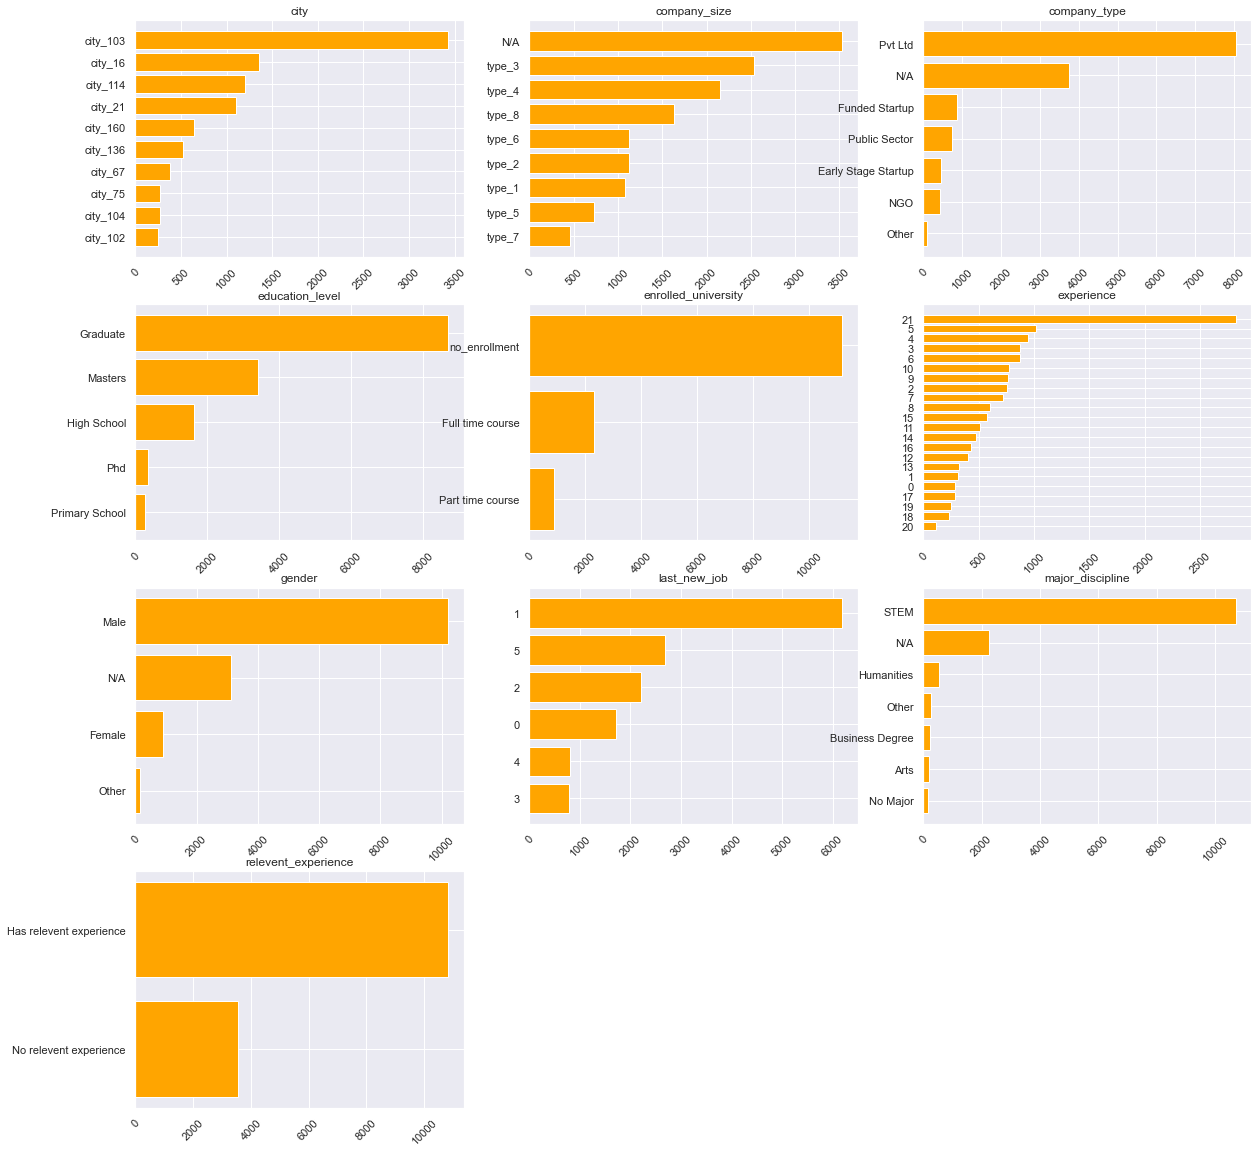

In [198]:
# Plotting all categorical columns for case where candidate stays
plt.figure(figsize=(20,20))
i=1
print('-----------------Candidate stays-----------------------')
for col in cat_cols:
    x,y=plot_cat(hr_train[col][hr_train.target==0])
    #since there are 100+ cities,only top 10 are being plotted
    if col=='city':
        x,y=x[-10:],y[-10:]
    plt.subplot(4,3,i)
    plt.barh(x,y,color='orange')
    plt.title(col)
    plt.xticks(rotation=45)
    i+=1 

1. From the above two sets of barplots, it can be seen that demographics of the candidate plays a somewhat important role in candidate retention
2. Next major factor is thetype of current employer

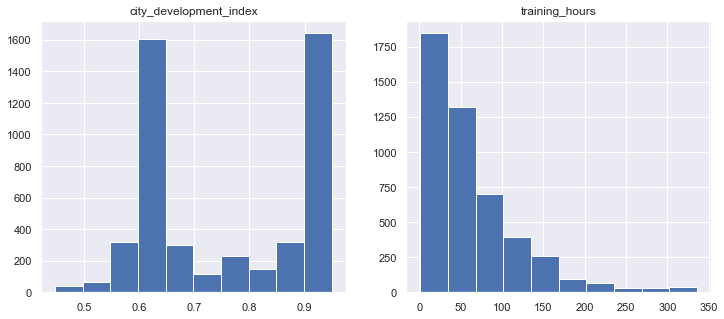

In [220]:
# Distribution of numerical variables for people who stay
i=1
plt.figure(figsize=(12,5))
for col in num_cols:
    plt.subplot(1,2,i)
    plt.hist(hr_train[col][hr_train.target==1])
    plt.title(col)
    i+=1

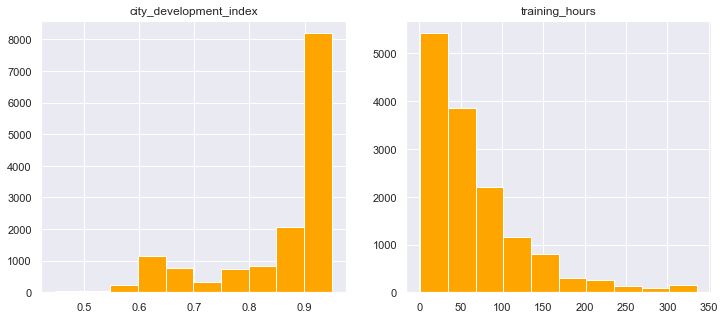

In [222]:
i=1
plt.figure(figsize=(12,5))
for col in num_cols:
    plt.subplot(1,2,i)
    plt.hist(hr_train[col][hr_train.target==0],color='orange')
    plt.title(col)
    i+=1

From the above plots it is evident that higher training hours lead to employee attrition. This may be interpreted in several ways
1. Higher number of training hours result in rapid skill and career improvement which inspire people to stay
2. People from developed cities tend to stay while those from underdeveloped cities tend to leave
